# RHS comparison

In [1]:
import sys
from itertools import combinations
from math import sin
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
from tqdm import tqdm

sys.path.append("../code/")

import xgi
from kuramoto_hoi import *

sb.set_theme(style="ticks", context="notebook")

## Definitions

In [2]:
def di_nearest_neigbors(N, d, r):
    """
    Create a d-uniform hypergraph representing nearest neighbor relationships.

    Parameters
    ----------
    N : int
        The total number of nodes.

    d : int
        Size of hyperedges

    r : int
        The range of neighbors to consider. Neighbors within the range [-r, r]
        (excluding the node itself) will be connected.

    Returns
    -------
    xgi.Hypergraph
        A hypergraph object representing the nearest neighbor relationships.
    """
    
    DH = xgi.DiHypergraph()
    nodes = np.arange(N)

    edges = []
    neighbor_rel_ids = np.concatenate((np.arange(-r, 0), np.arange(1, r + 1)))

    for i in nodes:
        neighbor_ids = i + neighbor_rel_ids
        edge_neighbors_i = combinations(neighbor_ids, d - 1)
        edges_i = [[list(np.mod(comb, N)), [i]] for comb in edge_neighbors_i]
        edges = edges + edges_i

    #edges = np.mod(edges, N)

    DH.add_nodes_from(nodes)
    DH.add_edges_from(edges)
    DH.cleanup()  # remove duplicate

    return DH

In [122]:
def rhs_max(t, psi, omega, k1, k2, links, triangles):
    N = len(psi)
    pairwise = np.zeros(N)
    triplet = np.zeros(N)
    for i, j in links:
        # sin(oj - oi)
        oi = psi[i]
        oj = psi[j]
        pairwise[i] += sin(oj - oi)
        pairwise[j] += sin(oi - oj)
        
    for i, j, k in triangles:
        # sin(2 oj - ok - oi)
        oi = psi[i]
        oj = psi[j]
        ok = psi[k]
        triplet[i] += 2 * sin(oj + ok - 2 * oi)
        triplet[j] += 2 * sin(oi + ok - 2 * oj)
        triplet[k] += 2 * sin(oj + oi - 2 * ok)
        
    return omega + pairwise + triplet

In [69]:
def rhs_dimax(t, psi, omega, k1, k2, dilinks, ditriangles):
    """
    RHS
    
    Parameters
    ----------
    k1, k2 : floats
        Pairwise and triplet coupling strengths
    r1, r2 : int
        Pairwise and triplet nearest neighbour ranges
    adj1 : ndarray, shape (N, N)
        Adjacency matrix of order 1
    triangles: list of sets
        List of unique triangles
    
    """
        
    N = len(psi)

    pairwise = np.zeros(N)
    
    for senders, receiver in dilinks:
        # sin(oj - oi)
        senders = list(senders)
        receiver = list(receiver)
        i = receiver
        j = senders
        oi = psi[i]
        oj = psi[j]
        pairwise[i] += sin(oj - oi)

    triplet = np.zeros(N)
    
    #print(len(triangles))
    for senders, receiver in ditriangles:
        # sin(oj + ok - 2 oi)
        senders = list(senders)
        receiver = list(receiver)
        i = receiver
        j = senders[0]
        k = senders[1]
        oi = psi[i]
        oj = psi[j]
        ok = psi[k]
        triplet[i] += 2 * sin(oj + ok - 2 * oi)
        
        #if print_i in [i, j, k]:
        #    print(i, j, k, "\t", f"{2 * sin(oj + ok - 2 * oi) * k2 / (r2 * (2 * r2 - 1)):.3f}")

    return omega + k1 * pairwise + k2 * triplet


In [102]:
def adjacency_tensor(H, order=2):
    N = H.num_nodes
    shape = tuple([N] * (order + 1))
    tensor = np.zeros(shape)

    edges = H.edges.filterby("order", order)
    for senders, receiver in edges.dimembers():
        ii = list(receiver)[0]
        for senders in permutations(senders, order):
            tensor[(ii, *senders)] = 1

    return tensor


def adjacency_tensor(H, order):
    N = H.num_nodes
    shape = tuple([N] * (order + 1))
    tensor = np.zeros(shape)

    edges = H.edges.filterby("order", order)
    for members in edges.members():
        for idcs in permutations(members):
            tensor[idcs] = 1

    return tensor

In [112]:
order = 2 
N = H.num_nodes
shape = tuple([N] * (order + 1))
tensor = np.zeros(shape)

edges = H.edges.filterby("order", order)
for members in edges.members():
    for idcs in permutations(members):
        print(idcs)
        tensor[idcs] = 1

(1, 2, 3)
(1, 3, 2)
(2, 1, 3)
(2, 3, 1)
(3, 1, 2)
(3, 2, 1)
(1, 2, 5)
(1, 5, 2)
(2, 1, 5)
(2, 5, 1)
(5, 1, 2)
(5, 2, 1)
(4, 5, 6)


IndexError: index 6 is out of bounds for axis 2 with size 6

In [113]:
H.nodes

NodeView((1, 2, 3, 4, 5, 6))

In [103]:
def ring_dihypergraph(N, r1, r2):

    H2 = di_nearest_neigbors(N, d=3, r=r2)
    H1 = di_nearest_neigbors(N, d=2, r=r1)
    
    DH = xgi.DiHypergraph()
    DH.add_nodes_from(H1.nodes)
    DH.add_edges_from(H1.edges.dimembers())
    DH.add_edges_from(H2.edges.dimembers())
    
    return DH

In [104]:
from itertools import permutations

def rhs_adj(t, psi, omega, k1, k2, adj1, adjt2):
    
    N = len(psi)
    sin_psi = np.sin(psi)
    cos_psi = np.cos(psi)

    sum_sin_psi = adjt2.dot(sin_psi)
    sum_cos_psi = adjt2.dot(cos_psi)

    pairwise = adj1.dot(sin_psi) * cos_psi - adj1.dot(cos_psi) * sin_psi

    triplet = (
        -2 * sum_cos_psi.dot(cos_psi) * sin_psi * cos_psi
        + 2 * sum_sin_psi.dot(sin_psi) * sin_psi * cos_psi
        + sum_cos_psi.dot(sin_psi) * cos_psi**2
        + sum_cos_psi.dot(sin_psi) * sin_psi**2
        + sum_sin_psi.dot(cos_psi) * cos_psi**2
        + sum_sin_psi.dot(cos_psi) * sin_psi**2
    )
    
    return omega + k1 * pairwise + k2 * triplet

In [114]:
# structural parameters
N = 83

r1 = 2
r2 = 2

#H = ring_dihypergraph(N, r1, r2)

edges = [[0, 2], [1, 2, 3], [1, 4], [1, 2, 5], [4, 5, 6]]
nodes = range(1, 6+1)

H = xgi.Hypergraph()
H.add_nodes_from(nodes)
H.add_edges_from(edges)

(<Axes: >,
 (<matplotlib.collections.PathCollection at 0x158542370>,
  <matplotlib.collections.PatchCollection at 0x15854ffd0>))

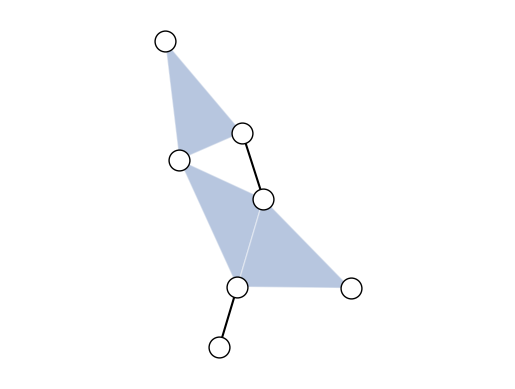

In [115]:
xgi.draw(H, edge_fc="b")

In [128]:
adj1 = adjacency_tensor(H, order=1)
adjt2 = adjacency_tensor(H, order=2)

In [129]:
# may be used in the simulation function
dilinks = H.edges.filterby("size", 2).members()
ditriangles = H.edges.filterby("size", 3).members()
#adj1 = xgi.adjacency_matrix(DH, order=1, sparse=False)

In [130]:
k1 = 1 #pairwise coupling strength
k2 = 2  # triplet coupling strength

t = 0
omega = 0

In [131]:
N = len(H)

psi = generate_state(N=N, kind="random", noise=0) # random state

In [132]:
y_dimax = rhs_max(t, psi, omega, 0, k2, dilinks, ditriangles)
y_adj = rhs_adj(t, psi, omega, 0, k2, adj1, adjt2)

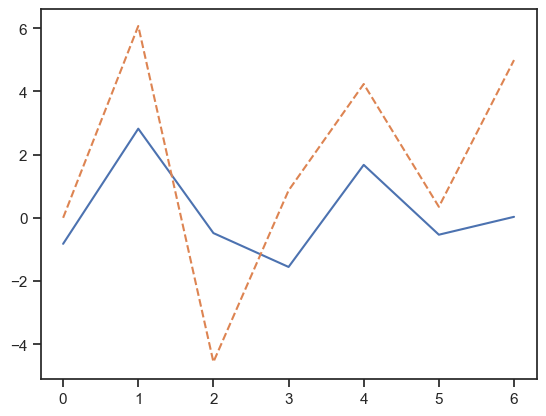

In [133]:
plt.plot(y_dimax)
plt.plot(y_adj, "--")

In [ ]:
adj1 = xgi.adjacency_matrix(H, order=1, sparse=False)
adjt2 = adjacency_tensor(H, order=2)

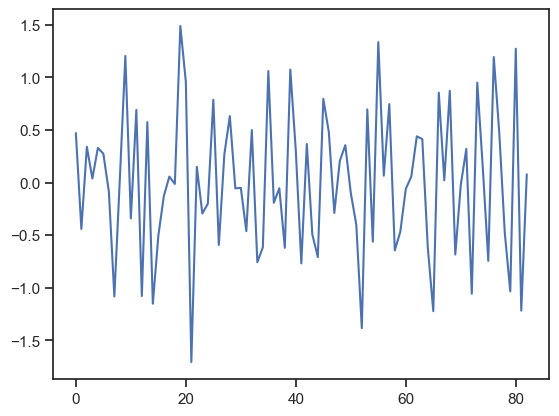

In [350]:
plt.plot(y_dimax - y_yuanzhao)

In [13]:
senders, receiver = DH.edges.dimembers()[-1]